우선, kaggle api 연결 -> kaggle dataset 다운로드 위해서

## Data Preprocessing
- (1) Frame Extraction : 영상을 프레임 단위로 나눠서 이미지 저장 (trump1.mp4, trump2.mp4, biden1.mp4, biden2.mp4)
- (2) Face Detection : 프레임 단위로 저장된 이미지에서 얼굴만 추출하여 다시 저장


### import modules & download datasets

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline
import cv2

In [ ]:
!cd /content/drive/MyDrive/project/FaceSwapping
!ls

drive  sample_data


In [ ]:
!kaggle datasets download -d sergiovirahonda/presidentsdataset

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
%cd /content/drive/MyDrive/project/FaceSwapping/input
!unzip -qq "presidentsdataset.zip"

/content/drive/MyDrive/project/FaceSwapping/input
unzip:  cannot find or open presidentsdataset.zip, presidentsdataset.zip.zip or presidentsdataset.zip.ZIP.


In [ ]:
%cd /content/drive/MyDrive/project/FaceSwapping/working/

/content/drive/MyDrive/project/FaceSwapping/working


In [ ]:
!mkdir frames_1
!mkdir frames_2
!mkdir frames_3
!mkdir frames_4
!mkdir results_1
!mkdir results_2
!ls

mkdir: cannot create directory ‘frames_1’: File exists
mkdir: cannot create directory ‘frames_2’: File exists
mkdir: cannot create directory ‘frames_3’: File exists
mkdir: cannot create directory ‘frames_4’: File exists
autoencoder_a.hdf5  final   frames_1  frames_3	results    results_2
autoencoder_b.hdf5  frames  frames_2  frames_4	results_1  transformed


# (1) Frame Extraction

In [13]:
input_1 = '/content/drive/MyDrive/project/FaceSwapping/input/presidents/trump1.mp4'
input_2 = '/content/drive/MyDrive/project/FaceSwapping/input/presidents/trump2.mp4'
input_3 = '/content/drive/MyDrive/project/FaceSwapping/input/presidents/biden1.mp4'
input_4 = '/content/drive/MyDrive/project/FaceSwapping/input/presidents/biden2.mp4'
output_1 = '/content/drive/MyDrive/project/FaceSwapping/working/frames_1/'
output_2 = '/content/drive/MyDrive/project/FaceSwapping/working/frames_2/'
output_3 = '/content/drive/MyDrive/project/FaceSwapping/working/frames_3/'
output_4 = '/content/drive/MyDrive/project/FaceSwapping/working/frames_4/'

def extract_frames(input_path,output_path):
    videocapture = cv2.VideoCapture(input_path)
    success,image = videocapture.read()
    count = 0
    while success:
        cv2.imwrite(output_path+"frame%d.jpg" % count, image)
        success,image = videocapture.read()
        count += 1
    return count

total_frames_1 = extract_frames(input_1,output_1)
total_frames_2 = extract_frames(input_2,output_2)
total_frames_3 = extract_frames(input_3,output_3)
total_frames_4 = extract_frames(input_4,output_4)

In [14]:
print('Total frames extracted in video 1: ',total_frames_1)
print('Total frames extracted in video 2: ',total_frames_2)
print('Total frames extracted in video 3: ',total_frames_3)
print('Total frames extracted in video 4: ',total_frames_4)

Total frames extracted in video 1:  1701
Total frames extracted in video 2:  1875
Total frames extracted in video 3:  1109
Total frames extracted in video 4:  1530


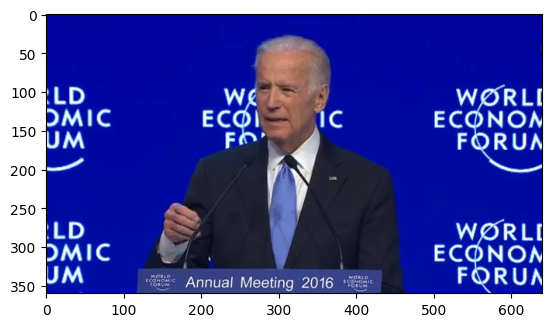

In [15]:
%matplotlib inline
plt.figure()
image = cv2.imread('/content/drive/MyDrive/project/FaceSwapping/working/frames_3/frame1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.astype('float32')
image /= 255.0
plt.imshow(image)
plt.show()

# (2) Face Detection

In [17]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.1 MB/s eta 0:00:00


1/1 [==============================] - 1s 1s/step


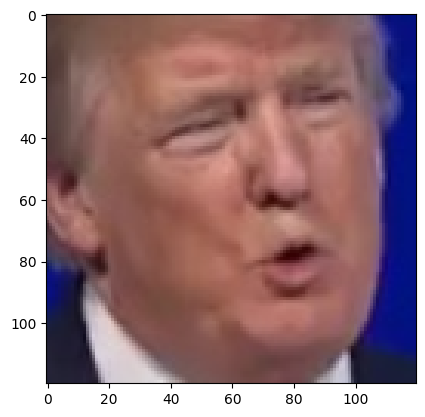

In [18]:
from mtcnn import MTCNN
import cv2

detector = MTCNN()
image = cv2.imread('/content/drive/MyDrive/project/FaceSwapping/working/frames_1/frame1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
detections = detector.detect_faces(image)
x, y, width, height = detections[0]['box']
x1,y1,x2,y2 = x-10,y+10,x-10 +width + 20,y+10+height
face = image[y1:y2, x1:x2]
#face = cv2.resize(face, (170, 170), interpolation=cv2.INTER_AREA) #if shape is > 120x120
face = cv2.resize(face, (120, 120), interpolation=cv2.INTER_LINEAR)
plt.imshow(face)
plt.show()

In [19]:
print(detections)

[{'box': [250, 51, 71, 90], 'confidence': 0.9999406337738037, 'keypoints': {'left_eye': (279, 87), 'right_eye': (307, 82), 'nose': (300, 102), 'mouth_left': (291, 122), 'mouth_right': (309, 119)}}]


In [20]:
def extract_faces(source_1,destination,detector):
    counter = 0
    for dirname, _, filenames in os.walk(source_1):
        for filename in filenames:
            try:
                image = cv2.imread(os.path.join(dirname, filename))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                detections = detector.detect_faces(image)
                x, y, width, height = detections[0]['box']
                x1,y1,x2,y2 = x-10,y+10,x-10 +width + 20,y+10+height
                face = image[y1:y2, x1:x2]
                face = cv2.resize(face, (120, 120), interpolation=cv2.INTER_LINEAR)
                plt.imsave(os.path.join(destination,str(counter)+'.jpg'),face)
                print('Saved: ',os.path.join(destination,str(counter)+'.jpg'))
            except:
                pass
            counter += 1
    print(counter)

In [21]:
detector = MTCNN()
extract_faces('/content/drive/MyDrive/project/FaceSwapping/working/frames_1/', '/content/drive/MyDrive/project/FaceSwapping/working/results_1/',detector)

1/1 [==============================] - 0s 151ms/step


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 30ms/step
Saved:  /content/drive/MyDrive/project/FaceSwapping/working/results_1/1284.jpg
1/1 [==============================] - 0s 32ms/step
Saved:  /content/drive/MyDrive/project/FaceSwapping/working/results_1/1285.jpg
1/1 [==============================] - 0s 27ms/step
Saved:  /content/drive/MyDrive/project/FaceSwapping/working/results_1/1286.jpg
1/1 [==============================] - 0s 29ms/step
Saved:  /content/drive/MyDrive/project/FaceSwapping/working/results_1/1287.jpg
1/1 [==============================] - 0s 32ms/step
Saved:  /content/drive/MyDrive/project/FaceSwapping/working/results_1/1288.jpg
1/1 [==============================] - 0s 27ms/step
Saved:  /content/drive/MyDrive/project/FaceSwapping/working/results_1/1289.jpg
1/1 [==============================] - 0s 27ms/step
Saved:  /content/drive/MyDrive/project/FaceSwapping/working/results_1/1290.jpg
1/1 [==============================] - 0s 32ms/

In [22]:
extract_faces('/content/drive/MyDrive/project/FaceSwapping/working/frames_3/','/content/drive/MyDrive/project/FaceSwapping/working/results_2/',detector)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 27ms/step
Saved:  /content/drive/MyDrive/project/FaceSwapping/working/results_2/692.jpg
1/1 [==============================] - 0s 26ms/step
Saved:  /content/drive/MyDrive/project/FaceSwapping/working/results_2/693.jpg
1/1 [==============================] - 0s 30ms/step
Saved:  /content/drive/MyDrive/project/FaceSwapping/working/results_2/694.jpg
1/1 [==============================] - 0s 27ms/step
Saved:  /content/drive/MyDrive/project/FaceSwapping/working/results_2/695.jpg
1/1 [==============================] - 0s 30ms/step
Saved:  /content/drive/MyDrive/project/FaceSwapping/working/results_2/696.jpg
1/1 [==============================] - 0s 28ms/step
Saved:  /content/drive/MyDrive/project/FaceSwapping/working/results_2/697.jpg
1/1 [==============================] - 0s 59ms/step
Saved:  /content/drive/MyDrive/project/FaceSwapping/working/results_2/698.jpg
1/1 [==============================] - 0s 29ms/step
Sa